In [49]:
import rioxarray
import pandas as pd
import numpy as np
import xarray as xr
sentinel_path = "/home/jupyter-haris/unmixing/rasters/S2_enmap_AOI.tif"
sentinel_path09 = "/home/jupyter-haris/unmixing/rasters/S2_enmap_AOI_09.tif"
sentinel_path11 = "/home/jupyter-haris/unmixing/rasters/S2_enmap_AOI_11.tif"
# Open the raster
ds = rioxarray.open_rasterio(sentinel_path)

# Extract band names
band_names = ds.attrs.get('long_name')

# Identify bands starting with 'B'
b_bands = [name for name in band_names if name.startswith('B')]

# Assign band names as coordinate
ds = ds.assign_coords(band=xr.DataArray(list(band_names), dims="band"))

# Filter to only those bands
b_ds = ds.sel(band=b_bands)

# Convert to (pixels, bands) flat DataFrame
# 1. Transpose to shape (y, x, band)
b_np = b_ds.transpose("y", "x", "band").values  # shape: (rows, cols, bands)

# 2. Flatten to 2D
n_rows, n_cols, n_bands = b_np.shape
flat = b_np.reshape(-1, n_bands)

# 3. Create DataFrame
df = pd.DataFrame(flat, columns=b_bands)
# 4. Interpolate NaNs (optional: method can be tuned)
df = df.interpolate(method='linear', axis=0, limit_direction='both')

# 5. Calculate PV+IR2 index
# Formula: ((B8 - B4) / (B8 + B4)) + ((B8 - B12) / (B8 + B12))
df['PV_IR2'] = ((df['B8'] - df['B4']) / (df['B8'] + df['B4'])) + \
               ((df['B8'] - df['B12']) / (df['B8'] + df['B12']))
# Add NDVI and NBR2 columns
df['NDVI'] = (df['B8'] - df['B4']) / (df['B8'] + df['B4'])
df['NBR2'] = (df['B11'] - df['B12']) / (df['B11'] + df['B12'])


In [50]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

# File paths
worldcover_path = "/home/jupyter-haris/unmixing/rasters/WorldCover_Crop_vs_Grass.tif"  # exported from GEE

# Open Sentinel-2 as reference
with rasterio.open(sentinel_path) as src_ref:
    ref_profile = src_ref.profile
    ref_transform = src_ref.transform
    ref_crs = src_ref.crs
    ref_shape = (src_ref.height, src_ref.width)

# Open WorldCover
with rasterio.open(worldcover_path) as src_wc:
    wc_data = src_wc.read(1)
    wc_transform = src_wc.transform
    wc_crs = src_wc.crs

    # Prepare empty array to hold reprojected/resampled data
    aligned_wc = np.empty(ref_shape, dtype=np.uint8)

    # Reproject and resample to match Sentinel-2 grid
    reproject(
        source=wc_data,
        destination=aligned_wc,
        src_transform=wc_transform,
        src_crs=wc_crs,
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        dst_shape=ref_shape,
        resampling=Resampling.nearest  # keep classes intact
    )


In [51]:
# HISET thresholding
from scipy.stats import gaussian_kde

# HISET thresholding 
def hi_set(h1, h2):
    h1_sorted = np.sort(h1)
    h2_sorted = np.sort(h2)
    n1 = len(h1_sorted)
    n2 = len(h2_sorted)

    all_vals = np.sort(np.unique(np.concatenate([h1, h2])))
    thresholds = (all_vals[:-1] + all_vals[1:]) / 2  # use midpoints for cleaner separation

    counts1 = np.searchsorted(h1_sorted, thresholds, side='left')
    counts2 = np.searchsorted(h2_sorted, thresholds, side='left')

    left_prop1 = counts1 / n1
    left_prop2 = counts2 / n2

    left_min  = np.minimum(left_prop1, left_prop2)
    right_min = np.minimum(1.0 - left_prop1, 1.0 - left_prop2)

    scores = np.maximum(left_min, right_min)
    best_idx = np.argmin(scores)
    best_thresh = thresholds[best_idx]
    best_score = scores[best_idx]
    return best_thresh, best_score


In [76]:
import rioxarray
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File paths
sentinel_paths = [
    "/home/jupyter-haris/unmixing/rasters/S2_enmap_AOI.tif",
    "/home/jupyter-haris/unmixing/rasters/S2_enmap_AOI_09.tif",
    "/home/jupyter-haris/unmixing/rasters/S2_enmap_AOI_11.tif"
]

# Index containers
index_stacks = {
    'PV+IR2': [],
    'NDVI': [],
    'NBR2': [],
    'BSI': [],
    'NDTI': [],
    'SAVI': [],
    'RI': [],
    'Custom': []
}

def compute_indices(b_np, b_bands):
    B2, B3, B4, B8, B11, B12 = [b_np[..., b_bands.index(f'B{i}')] for i in [2, 3, 4, 8, 11, 12]]

    # Original indices
    pvir2 = ((B8 - B4) / (B8 + B4)) + ((B8 - B12) / (B8 + B12))
    ndvi = (B8 - B4) / (B8 + B4)
    nbr2 = (B8 - B11) / (B8 + B11)
    bsi = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))
    ndti = (B11 - B12) / (B11 + B12)
    savi = ((B8 - B4) / (B8 + B4 + 0.5)) * 1.5
    ri = (B4 ** 2) / (B3 * B2)

    # Combination index
    pvir2_minus_savi = pvir2 - savi

    return {
        'PV+IR2': pvir2,
        'NDVI': ndvi,
        'NBR2': nbr2,
        'BSI': bsi,
        'NDTI': ndti,
        'SAVI': savi,
        'RI': ri,
        'Custom': pvir2_minus_savi
    }


# Read each raster and compute all indices
for path in sentinel_paths:
    ds = rioxarray.open_rasterio(path)
    ds = ds.assign_coords(band=xr.DataArray(list(ds.attrs['long_name']), dims="band"))
    b_ds = ds.sel(band=b_bands)
    b_np = b_ds.transpose("y", "x", "band").values

    indices = compute_indices(b_np, b_bands)
    for key, arr in indices.items():
        index_stacks[key].append(arr)

def analyze_index(index_stack, aligned_wc, label, plot=False):
    index_np = np.stack(index_stack, axis=0)
    min_index = np.nanmin(index_np, axis=0)

    min_flat = min_index.flatten()
    min_df = pd.DataFrame({'index': min_flat, 'landcover': aligned_wc.flatten()})

    crop_vals = min_df.loc[min_df['landcover'] == 1, 'index'].dropna()
    grass_vals = min_df.loc[min_df['landcover'] == 2, 'index'].dropna()

    threshold, score = hi_set(crop_vals.values, grass_vals.values)

    if plot:
        plt.hist(crop_vals, bins=100, alpha=0.5, label='Cropland')
        plt.hist(grass_vals, bins=100, alpha=0.5, label='Grassland')
        plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.3f}')
        plt.title(f'HISET for {label}')
        plt.legend()
        plt.show()

    return threshold, score

def run_all_index_analysis(index_stacks, aligned_wc, plot=False):
    results = {}
    for name, stack in index_stacks.items():
        threshold, score = analyze_index(stack, aligned_wc, name, plot=plot)
        results[name] = {'threshold': threshold, 'score': score}
    return results

# Run analysis (set plot=True to visualize histograms)
thresholds = run_all_index_analysis(index_stacks, aligned_wc, plot=False)

# View results
for name, vals in thresholds.items():
    print(f"{name}: Threshold = {vals['threshold']:.3f}, Score = {vals['score']:.3f}")


/tmp/ipykernel_3297151/2080643579.py:66: RuntimeWarning: All-NaN slice encountered
  min_index = np.nanmin(index_np, axis=0)


PV+IR2: Threshold = 0.261, Score = 0.173
NDVI: Threshold = 0.220, Score = 0.185
NBR2: Threshold = -0.084, Score = 0.205
BSI: Threshold = 0.045, Score = 0.247
NDTI: Threshold = 0.118, Score = 0.146
SAVI: Threshold = 0.330, Score = 0.185
RI: Threshold = 1.232, Score = 0.255
Custom: Threshold = -0.079, Score = 0.190


In [68]:
# # Run analysis (set plot=True to visualize histograms)
# thresholds = run_all_index_analysis(index_stacks, aligned_wc, plot=True)

# # View results
# for name, vals in thresholds.items():
#     print(f"{name}: Threshold = {vals['threshold']:.3f}, Score = {vals['score']:.3f}")


In [78]:
# Flatten the aligned land cover mask
lc_flat = aligned_wc.flatten()
df['landcover'] = lc_flat

# threshold=0.32
df['pixel_class'] = 0  # default to 'other'
# Cropland and grassland classification
cropland = df['landcover'] == 1
grassland = df['landcover'] == 2

threshold = thresholds['PV+IR2']['score']


df.loc[cropland & (df['PV_IR2'] < threshold), 'pixel_class'] = 1  # soil
df.loc[cropland & (df['PV_IR2'] >= threshold), 'pixel_class'] = 2  # veg
df.loc[grassland & (df['PV_IR2'] < threshold), 'pixel_class'] = 1  # soil
df.loc[grassland & (df['PV_IR2'] >= threshold), 'pixel_class'] = 2  # veg
df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,PV_IR2,NDVI,NBR2,landcover,pixel_class
0,1325.5,1527.0,1794.5,1878.0,2268.0,2955.5,3178.0,3305.0,3434.0,3455.0,3270.0,2660.0,0.383454,0.275323,0.102867,0,0
1,1325.5,1527.0,1794.5,1878.0,2268.0,2955.5,3178.0,3305.0,3434.0,3455.0,3270.0,2660.0,0.383454,0.275323,0.102867,0,0
2,1325.5,1527.0,1794.5,1878.0,2268.0,2955.5,3178.0,3305.0,3434.0,3455.0,3270.0,2660.0,0.383454,0.275323,0.102867,0,0
3,1325.5,1527.0,1794.5,1878.0,2268.0,2955.5,3178.0,3305.0,3434.0,3455.0,3270.0,2660.0,0.383454,0.275323,0.102867,0,0
4,1325.5,1527.0,1794.5,1878.0,2268.0,2955.5,3178.0,3305.0,3434.0,3455.0,3270.0,2660.0,0.383454,0.275323,0.102867,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9578005,1652.0,2192.0,2390.0,2402.0,2547.0,2779.0,2855.0,2866.0,2950.0,2947.0,2956.0,2488.0,0.158680,0.088079,0.085966,0,0
9578006,1652.0,2012.0,2274.0,2236.0,2547.0,2779.0,2855.0,2763.0,2950.0,2947.0,2956.0,2488.0,0.157792,0.105421,0.085966,0,0
9578007,1652.0,2004.0,2230.0,2208.0,2464.0,2777.0,2845.0,2866.0,2937.0,2947.0,2852.0,2344.0,0.229873,0.129681,0.097768,0,0
9578008,1652.0,2004.0,2230.0,2208.0,2464.0,2777.0,2845.0,2866.0,2937.0,2947.0,2852.0,2344.0,0.229873,0.129681,0.097768,2,2


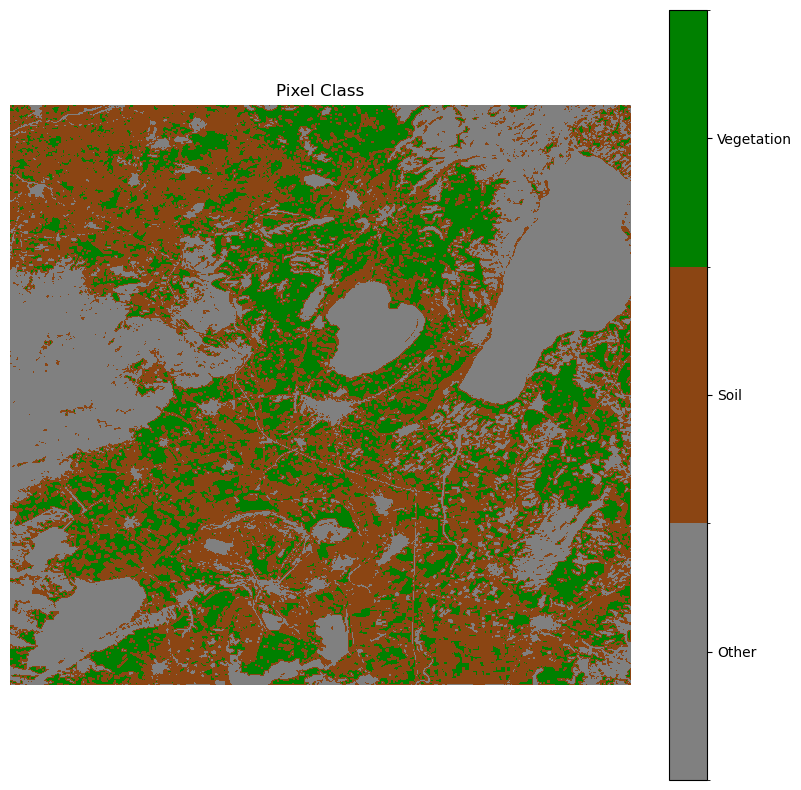

In [79]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Reshape flat array back to 2D
pixel_class_img = df['pixel_class'].values.reshape(n_rows, n_cols)

# Define a colormap for 0=other, 1=soil, 2=veg
cmap = mcolors.ListedColormap(['gray', 'saddlebrown', 'green'])
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(pixel_class_img, cmap=cmap, norm=norm)
cbar = plt.colorbar(ticks=[0.5, 1.5, 2.5])
cbar.ax.set_yticklabels(['Other', 'Soil', 'Vegetation'])
plt.title('Pixel Class')
plt.axis('off')
plt.show()


In [48]:
import rasterio

# Output path
output_path = "bare_soil_mask_026.tif"

# Re-open reference raster to get spatial metadata
with rasterio.open(sentinel_path) as src:
    profile = src.profile
    profile.update({
        "count": 1,
        "dtype": rasterio.uint8,
        "compress": "lzw"
    })

    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(pixel_class_img.astype(np.uint8), 1)
